In [2]:
import pandas as pd
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [3]:
column_input = 'comment'
test_size = 0.3
seed = 42

In [4]:
def cross_validation(splits, X, y, pipeline, average_method):   
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for train, test in kfold.split(X, y):
        model_fit = pipeline.fit(X[train], y[train])
        predicted = model_fit.predict(X[test])
        
        # accuracy
        scores = model_fit.score(X[test], y[test])
        accuracies.append(scores)
        
        # precision
        precision = precision_score(y[test], predicted, average=average_method)
        precisions.append(precision)
        
        # recell
        recall = recall_score(y[test], predicted, average=average_method)
        recalls.append(recall)
        
        # f1
        f1 = f1_score(y[test], predicted, average=average_method)
        f1_scores.append(f1)

#     print('Classifcation report:\n', classification_report(y[test], predicted))
        
#     # confusion matrix
#     conf_mat = confusion_matrix(y_true=y[test], y_pred=predicted)
#     print('Confusion matrix:\n', conf_mat)
    
    print("accuracy: %.2f (+/- %.2f)" % (np.mean(accuracies), np.std(accuracies)))
    print("precision: %.2f (+/- %.2f)" % (np.mean(precisions), np.std(precisions)))
    print("recall: %.2f (+/- %.2f)" % (np.mean(recalls), np.std(recalls)))
    print("f1 score: %.2f (+/- %.2f)" % (np.mean(f1_scores), np.std(f1_scores)))

In [5]:
with open('data/all.json') as data_file:    
    data = json.load(data_file)

In [6]:
df = pd.DataFrame.from_dict(data, orient='columns')

In [8]:
df['category_id'] = df['label'].factorize()[0]

In [9]:
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

{'Bug': 0, 'Rating': 1, 'Feature': 2, 'UserExperience': 3}


In [10]:
id_to_category = dict(category_id_df[['category_id', 'label']].values)
print(id_to_category)

{0: 'Bug', 1: 'Rating', 2: 'Feature', 3: 'UserExperience'}


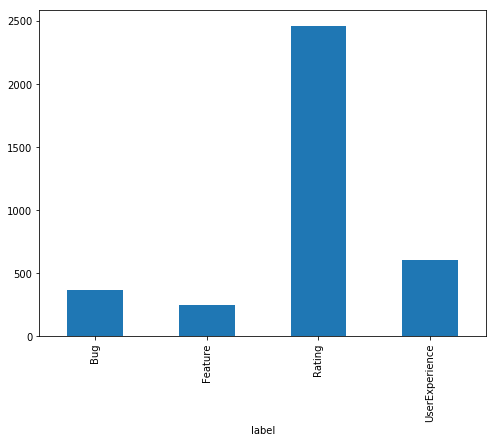

In [11]:
fig = plt.figure(figsize=(8,6))
df.groupby('label')[column_input].count().plot.bar(ylim=0)
plt.show()

In [12]:
print(pd.value_counts(pd.Series(df['label'])))

Rating            2462
UserExperience     607
Bug                370
Feature            252
Name: label, dtype: int64


In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

vectorizer = CountVectorizer()
vectorizer.fit(df[column_input])
print(vectorizer.vocabulary_)

vector = vectorizer.transform(df[column_input])

print(vector.shape)
print(type(vector))
print(vector.toarray())

{'besides': 611, 'the': 5003, 'occasional': 3470, 'crash': 1210, 'this': 5029, 'is': 2669, 'an': 311, 'amazing': 299, 'product': 3922, 'with': 5545, 'tons': 5095, 'of': 3480, 'potential': 3851, 'depending': 1346, 'on': 3502, 'how': 2435, 'you': 5642, 'work': 5563, 'it': 2677, 'could': 1179, 'be': 571, 'great': 2234, 'app': 361, 'if': 2478, 'was': 5438, 'predictable': 3870, 'but': 788, 'full': 2080, 'bugs': 766, 'and': 314, 'unpredictable': 5267, 'are': 406, 'able': 124, 'to': 5085, 'check': 916, 'in': 2523, 'take': 4931, 'screen': 4400, 'shot': 4521, 'your': 5644, 'boarding': 670, 'pass': 3645, 'or': 3539, 'print': 3904, 'backup': 518, 'copy': 1166, 'because': 583, 'may': 3119, 'not': 3420, 'access': 141, 'when': 5498, 'need': 3363, 'most': 3275, 'can': 822, 'open': 3517, 'since': 4558, 'last': 2832, 'updates': 5284, 'pop': 3830, 'ups': 5298, 'go': 2179, 'crazy': 1215, 'iphone': 2660, 'uninstalling': 5254, 'use': 5316, 'love': 2989, 'working': 5566, 'after': 223, 'new': 3381, 'update':

In [15]:
features = tfidf.fit_transform(df[column_input])
labels = df.category_id

print(df[column_input][0])

print(features.shape)
print(labels.shape)

Besides the occasional crash, this is an amazing product with tons of potential depending on how you work with it!
(3691, 27402)
(3691,)


In [14]:
from collections import Counter
print('Original dataset shape %s' % Counter(labels))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features, labels)
print('SMOTE dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 2462, 3: 607, 0: 370, 2: 252})
SMOTE dataset shape Counter({0: 2462, 1: 2462, 2: 2462, 3: 2462})


In [ ]:
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [ ]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=seed),
]

In [ ]:
splits = 5

for model in models:
    print(model.__class__.__name__)
    print()
    
    pipeline = make_pipeline(SMOTE(random_state=seed), model)
    cross_validation(splits, features, labels, pipeline, 'macro')
    
    print()
    

In [ ]:
# best_score = 0

# for item in accuracy_model_tuples:
#     if item[1] > best_score:
#         best_score = item[1]
#         best_model = (item[0], item[1])

# print(best_model)

In [ ]:
texts = ["I like yelp but I wish it didn't force you to download the app because I don't have a lot of space",
         "Very helpful app, highly recommend",
         "notifications dont pop up. keeps spinning and spinning",
         "Great game but way to many ads I get that a free to play game needs ads which I'm fine with but this has a and after every level and each level is max of about 30 seconds long"]
text_features = tfidf.transform(texts)
predictions = models[2].predict(text_features)

for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
# model.fit(features, labels)
# N = 2
# for label, category_id in sorted(category_to_id.items()):
#   indices = np.argsort(model.coef_[category_id])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#   bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#   print("# '{}':".format(label))
#   print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#   print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=seed)

In [ ]:
# accuracy_model_tuples = []

# print("Feature: ", column_input)
# print()

# for model in models:
#     print(model)
#     print()
    
#     model.fit(X_resampled, y_resampled)
#     predicted = model.predict(X_test)
 
#     print('Classifcation report:\n', classification_report(y_test, predicted))
    
#     accuracy = accuracy_score(y_test, predicted)
#     print('accuracy: ', accuracy)
#     print()
    
#     conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
#     print('Confusion matrix:\n', conf_mat)

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.show()
    
#     accuracy_model_tuples.append((model, accuracy))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df[column_input], df['label'], test_size=test_size, random_state=seed)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# print(clf.predict(count_vect.transform(["Besides the occasional crash, this is an amazing product with tons of potential depending on how you work with it!"])))

In [ ]:
import itertools
import os
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

X_train, X_test, y_train, y_test = train_test_split(df[column_input], df['label'], test_size=test_size, random_state=seed)

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train)

X_train = tokenize.texts_to_matrix(X_train)
X_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [ ]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('BoW with Keras')
print('Test score:', score[0])
print('Test accuracy:', score[1])